In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

################################
#      Discriminator 설계      #
################################

class MNIST_Discriminator(nn.Module):

  def __init__(self, config):
    super(MNIST_Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["d_input_node"]
    # 은닉층 노드 수
    self.hnode = config["d_hidden_node"]
    # 출력층 노드 수: 분류해야 하는 레이블 수
    self.onode = config["d_output_node"]

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Sigmoid())
    
  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis

################################
#        Generator 설계        #
################################

class MNIST_Generator(nn.Module):

  def __init__(self, config):
    super(MNIST_Generator, self).__init__()

    # 입력층 노드 수
    self.inode = config["g_input_node"]
    # 은닉층 노드 수
    self.hnode = config["g_hidden_node"]
    # 출력층 노드 수: 생성해야 하는 노드 수
    self.onode = config["g_output_node"]

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Tanh())

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis

In [ ]:
def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [ ]:
# 데이터 읽기 함수
def load_dataset():
  standardizator = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
  # MNIST dataset
  train_X = datasets.MNIST(root='/gdrive/My Drive/colab/gan/mnist/data/', train=True, transform=standardizator, download=True)    
  return train_X

In [ ]:
def get_noise(batch_size=16, g_input_node=100):
    return torch.randn(batch_size, g_input_node)

def do_test(model, input_node):
  # 평가 모드 셋팅
  model.eval()

  with torch.no_grad():

    X = get_noise(g_input_node=input_node).cuda()
    hypothesis = model(X)
    hypothesis_ = hypothesis.reshape((-1,28,28)).unsqueeze(1)
    imshow_grid(hypothesis_)  

In [ ]:
# 모델 학습 함수
def train(config):

  # Discriminator와 Generator 모델 생성
  # 이곳을 채우세요.
  D = MNIST_Discriminator(config).cuda()
  G = MNIST_Generator(config).cuda()

  # 데이터 읽기
  input_features = load_dataset()
  
  # DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
  train_dataloader = DataLoader(input_features, shuffle=True, batch_size=config["batch_size"])

  # 바이너리 크로스엔트로피 비용 함수 
  loss_func = nn.BCELoss()

  # Discriminator와 Generator 옵티마이저 함수 지정
  # 이곳을 채우세요.
  D_optimizer = torch.optim.Adam(D.parameters(), lr = config["learn_rate"])
  G_optimizer = torch.optim.Adam(G.parameters(), lr = config["learn_rate"])

  for epoch in range(config["epoch"]+1):

    # Discriminator와 Generator 학습 모드 셋팅
    D.train()
    G.train()
    
    # epoch 마다 평균 비용을 저장하기 위한 리스트
    D_costs, G_costs = [], []

    for (step, batch) in enumerate(train_dataloader):

      # batch = (input_features[step], labels[step])*batch_size
      # .cuda()를 통해 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)

      # 배치 크기 만큼 입력 데이터 읽기 
      input_features, _ = batch
      input_features = input_features.view(-1,config['d_input_node'])
      
      ################################
      #      Discriminator 학습      #
      ################################

      # 역전파 변화도 초기화
      D_optimizer.zero_grad()
 
      # 진짜에 대한 비용 계산
      real_hypothesis = D(input_features)
      real_labels = Variable(torch.ones(config["batch_size"],1)).cuda()
      real_cost = loss_func(real_hypothesis, real_labels)
      
      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      fake_hypothesis = D(G(fake_input_features))
      fake_labels = Variable(torch.zeros(config["batch_size"],1)).cuda()
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      # 전체 비용 역전파 수행
      # 이곳을 채우세요.
      total_cost = real_cost + fake_cost
      total_cost.backward()
      D_optimizer.step()

      # 현재 batch의 스텝 별 Discrimnator 비용 저장
      D_costs.append(total_cost.data.item())

      ################################
      #        Generator 학습        #
      ################################
 
      # 역전파 변화도 초기화
      G_optimizer.zero_grad()

      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      # 이곳을 채우세요.
      fake_hypothesis = D(G(fake_input_features))
      fake_labels = Variable(torch.ones(config["batch_size"],1)).cuda()
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      # 가짜 생성 비용 역전파 수행
      fake_cost.backward()
      G_optimizer.step()

      # 현재 batch의 스텝 별 Generator 비용 저장
      G_costs.append(fake_cost.data.item())
    
    # 10 에폭마다 중간 결과 출력 및 저장
    if epoch%10 == 0:
    
      # 평균 비용 출력
      print("Avg Loss D={0:f}, Avg Loss G={1:f}".format(np.mean(D_costs), np.mean(G_costs)))

      # Generator 저장
      torch.save(G.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

      # 생성된 샘플 출력
      do_test(G,config['g_input_node'])

Avg Loss D=0.290583, Avg Loss G=4.216723


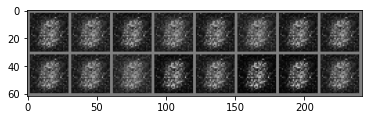

Avg Loss D=0.348157, Avg Loss G=3.421209


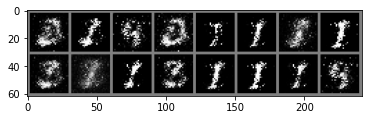

Avg Loss D=0.550822, Avg Loss G=2.382135


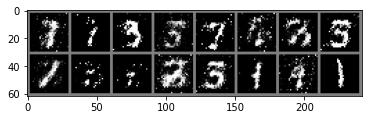

Avg Loss D=0.710286, Avg Loss G=1.916378


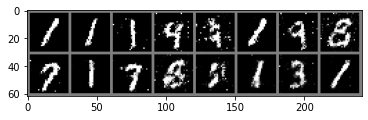

Avg Loss D=0.785795, Avg Loss G=1.755699


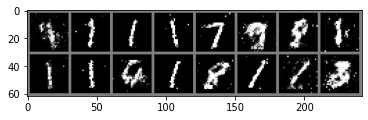

Avg Loss D=0.862928, Avg Loss G=1.591183


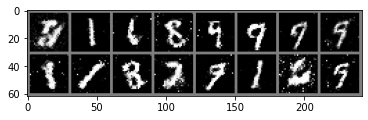

Avg Loss D=0.899876, Avg Loss G=1.519360


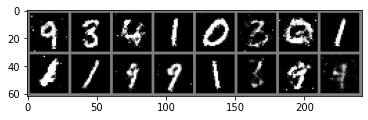

Avg Loss D=0.926247, Avg Loss G=1.453251


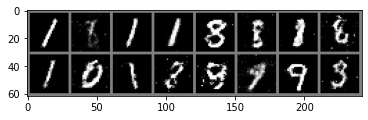

Avg Loss D=0.941087, Avg Loss G=1.425824


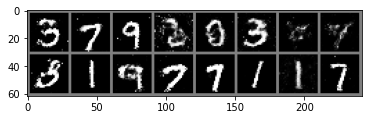

Avg Loss D=0.945799, Avg Loss G=1.404842


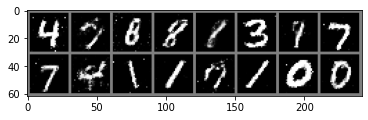

Avg Loss D=0.958899, Avg Loss G=1.398410


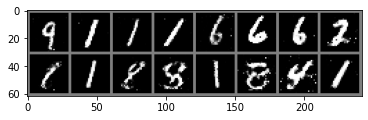

In [ ]:
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/colab/gan/mnist"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"model_name":"epoch_{0:d}.pt".format(10),
              "root_dir":root_dir,
              "output_dir":output_dir,
              "d_input_node":784,
              "d_hidden_node":256,
              "d_output_node":1,
              "g_input_node":100,
              "g_hidden_node":256,
              "g_output_node":784,
              "learn_rate":0.0002,
              "batch_size":100,
              "epoch":100,
              }

    train(config)